<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/VIT_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 34.76 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
#Prepare transform
img_size = 224

manual_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()
])
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [7]:
#batch size
batch = 32
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform=manual_transform,
    batch_size = batch
)

In [8]:
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7de74d2ec590>,
 ['pizza', 'steak', 'sushi'])

In [9]:
#visualize
image_batch,label_batch = next(iter(train_dataloader))

In [10]:
image,label = image_batch[1],label_batch[1]
image.shape,label.item()

(torch.Size([3, 224, 224]), 0)

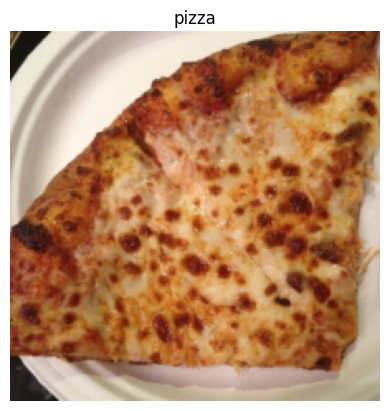

In [11]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label.item()])
plt.axis(False);

In [12]:
#Examples
input_embedding_layer_shape = (224,224,3)#heigth(H),width(W),color channels
patch_size = 16

#Number of patches,N
N = int(input_embedding_layer_shape[0] * input_embedding_layer_shape[1]/patch_size **2)# H*W/patch_size**2
print(f'Patch Number: {N}')

Patch Number: 196


In [13]:
#Embedding_output_shape -> (N ,patch_size^2 * color channels)
outputs_embedding_layer_shape = (N,patch_size**2 * input_embedding_layer_shape[2])
print(f'input_embedding_layer_shape: {input_embedding_layer_shape}')
print(f'output_layer_embedding_shape: {outputs_embedding_layer_shape}')

input_embedding_layer_shape: (224, 224, 3)
output_layer_embedding_shape: (196, 768)


View of single image patches

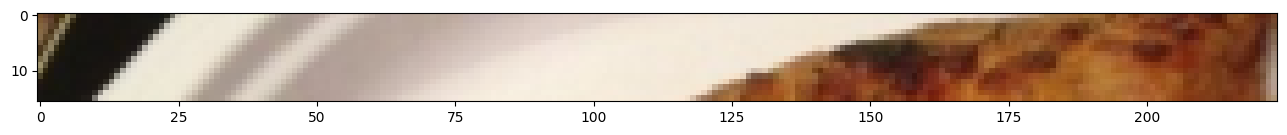

In [14]:
permuted_image = image.permute(1,2,0)#change from (C,H,W) -> (H,W,C)
Patch_size = 16
plt.figure(figsize=(Patch_size,Patch_size))
plt.imshow(permuted_image[:Patch_size,:,:])


14 patches per row
patch size  -> 16 x 16


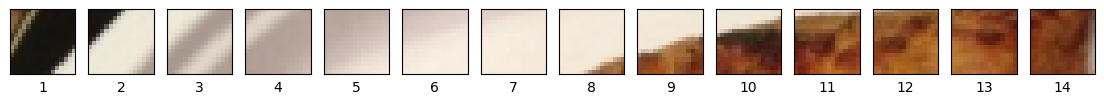

In [15]:
#patches
img_sz = 224
num_patches = img_sz/Patch_size
assert img_sz % Patch_size == 0, "Image size must be divisible by patch size"
fig,axs = plt.subplots(nrows=1,
                      ncols=img_sz//Patch_size,
                      figsize=(14,14))
print(f'{int(num_patches)} patches per row')
print(f'patch size  -> 16 x 16')
#patches in top row
for i,patch  in enumerate(range(0,img_sz,Patch_size)):
  print
  axs[i].imshow(permuted_image[:Patch_size,patch:patch+Patch_size,:]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])



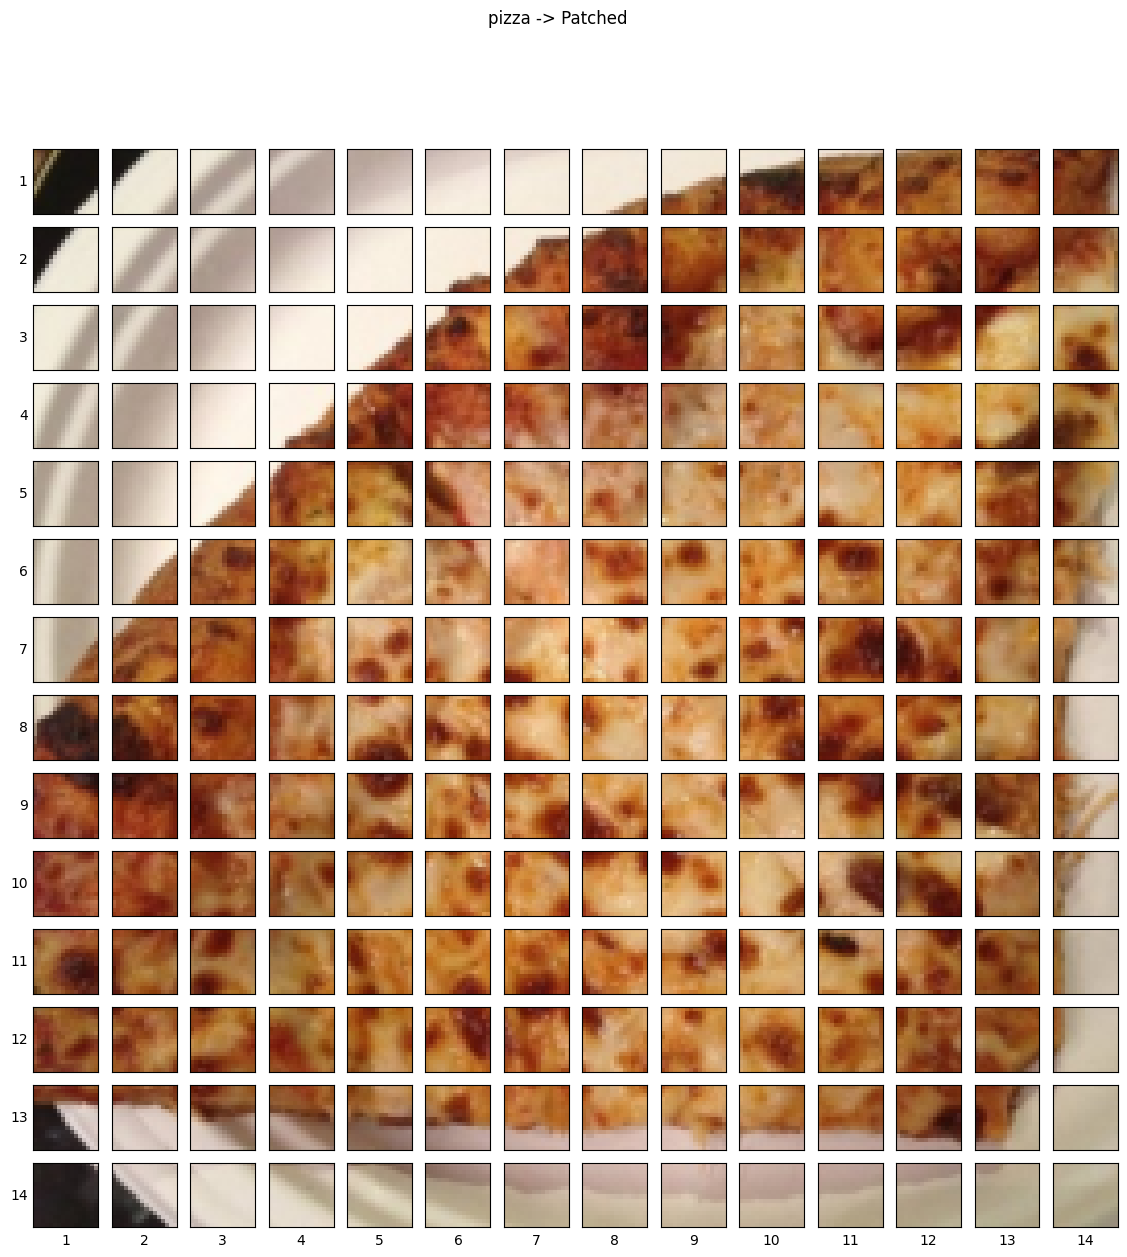

In [16]:
image_size = 224
patch_size = 16
num_patches = image_size/patch_size
assert image_size % patch_size == 0, "Image size must be divisible by patch size"
fig,axs = plt.subplots(nrows=14,
                       ncols=14,
                       sharex=True,
                       sharey=True,
                       figsize=(14,14))
#iterate through width and height
for i ,patch_h in enumerate(range(0,image_size,patch_size)):
  for j,patch_w in enumerate(range(0,image_size,patch_size)):
    axs[i,j].imshow(permuted_image[patch_h:patch_h+patch_size,patch_w:patch_w+patch_size,:]);
    axs[i,j].set_ylabel(i+1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()
fig.suptitle(f'{class_names[label.item()]} -> Patched')
plt.show()


Turn  image into patches and enbeddings

In [17]:
#example
patch_size = 16

conv = nn.Conv2d(in_channels=3,
                 out_channels=768,
                 kernel_size=patch_size,
                 stride=patch_size,
                 padding=0)
conv

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [18]:
#f -> feature_map
img_out = conv(image.unsqueeze(0))
img_out.shape #  [batch_size,input_embed_dim,f_map_h,f_map_w]

torch.Size([1, 768, 14, 14])

Plotting feature  maps -> [614, 223, 131, 545, 311]


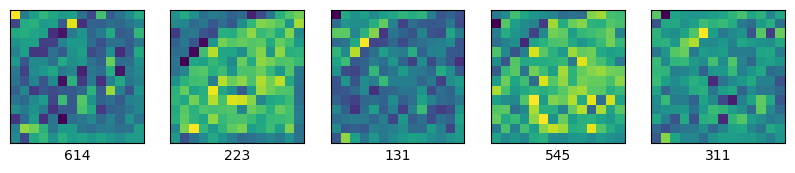

In [19]:
#feature maps
import  random
random_indxs = random.sample(range(0,758),k=5)

fig,axs = plt.subplots(nrows=1,
                       ncols=5,
                       figsize=(10,10))
print(f'Plotting feature  maps -> {random_indxs}')
for i,sample in enumerate(random_indxs):
  axs[i].imshow(img_out[:,sample,:,:].squeeze().detach().numpy())
  axs[i].set_xlabel(sample)
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [20]:
img_out.shape

torch.Size([1, 768, 14, 14])

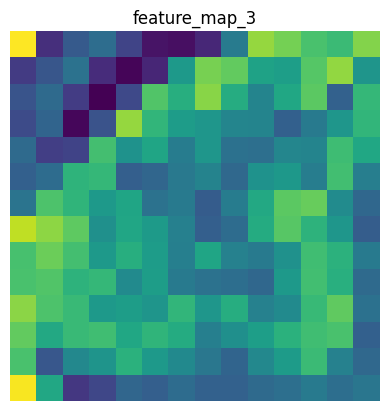

In [21]:
#single f_map
plt.imshow(img_out[:,3,:,:].squeeze().detach().numpy())
plt.title('feature_map_3')
plt.axis(False)
plt.show()

In [22]:
#Flatten -> [batch_size,  embed_dim, no. of  patches]
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_image=flatten_layer(img_out)
flatten_image.shape


torch.Size([1, 768, 196])

In [23]:
flatten_image_new = flatten_image.permute(0,2,1)
flatten_image_new.shape

torch.Size([1, 196, 768])

In [24]:
#plot flattened map
plt.figure(figsize=(22,22))
plt.imshow(flatten_image_new[:,:,0].detach().numpy())
plt.axis(False)
plt.show()

###Equation 1

In [25]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels=3,
               patch_size=16,
               embedding_size=768):
     super().__init__()

     self.patcher = nn.Conv2d(in_channels=in_channels,
                              out_channels=embedding_size,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)
     self.Flatten = nn.Flatten(start_dim=2,
                               end_dim=3)

  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution  % patch_size  ==0,f'Image should be divisble by patch_size'
    x_flatten = self.Flatten(self.patcher(x))
    return x_flatten.permute(0,2,1)



In [26]:
patchify  = PatchEmbedding()
patches = patchify.forward(image.unsqueeze(0))
patches.shape

torch.Size([1, 196, 768])

Class Tokens

In [27]:
batch_size = patches.shape[0]
embed_dim_size = patches.shape[-1]
class_Tokens = nn.Parameter(torch.ones(batch_size,1,embed_dim_size),
                            requires_grad=True)
class_Tokens.shape

torch.Size([1, 1, 768])

In [28]:
added_class_tokens = torch.cat((class_Tokens,patches),dim=1)
added_class_tokens,added_class_tokens.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2318,  0.1564,  0.0275,  ..., -0.1124, -0.1036, -0.0250],
          [-0.0538,  0.4038,  0.4391,  ..., -0.0958, -0.1686,  0.2124],
          ...,
          [-0.1168,  0.3690,  0.2015,  ..., -0.1585, -0.1633, -0.0809],
          [-0.1057,  0.4106,  0.2392,  ..., -0.1475, -0.1533, -0.0373],
          [-0.0792,  0.4047,  0.1793,  ..., -0.1735, -0.1207, -0.0942]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [29]:
#position embedding
number_of_patches = N
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embed_dim_size),
                                  requires_grad=True)
position_embedding,position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [30]:
added_position_embedding = added_class_tokens + position_embedding
added_position_embedding,added_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7682, 1.1564, 1.0275,  ..., 0.8876, 0.8964, 0.9750],
          [0.9462, 1.4038, 1.4391,  ..., 0.9042, 0.8314, 1.2124],
          ...,
          [0.8832, 1.3690, 1.2015,  ..., 0.8415, 0.8367, 0.9191],
          [0.8943, 1.4106, 1.2392,  ..., 0.8525, 0.8467, 0.9627],
          [0.9208, 1.4047, 1.1793,  ..., 0.8265, 0.8793, 0.9058]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

Put all together

In [31]:
set_seeds()
patch_size  =  16

print(f'Image shape -> {image.shape}')
H,W = image.shape[1],image.shape[2]

x = image.unsqueeze(0)
print(f'image input shape -> {x.shape}')

#patch
patch_embedding = PatchEmbedding()
patches = patch_embedding(x)
print(f'patch_embedding  shape -> {patches.shape}')

#class tokens
batch_size = patches.shape[0]
embed_size = patches.shape[-1]
class_tokens = nn.Parameter(torch.ones(batch_size,1,embed_size),
                            requires_grad=True)
print(f'class tokens shape -> {class_tokens.shape}')

#prepend to patch embedding
added_tokens = torch.cat((patches,class_tokens),dim=1)
print(f'added tokens shape -> {added_tokens.shape}')

#positional embeddings
positional_embeddings = nn.Parameter(torch.ones(1,N+1,embed_size),#N -> number of patches
                                    requires_grad=True)
print(f'shape of positional embedding -> {positional_embeddings.shape}')

#add to added_tokens
with_positional_embeddings = added_tokens + positional_embeddings
print(f'final shape with positional embeddings-> {with_positional_embeddings.shape}')

Image shape -> torch.Size([3, 224, 224])
image input shape -> torch.Size([1, 3, 224, 224])
patch_embedding  shape -> torch.Size([1, 196, 768])
class tokens shape -> torch.Size([1, 1, 768])
added tokens shape -> torch.Size([1, 197, 768])
shape of positional embedding -> torch.Size([1, 197, 768])
final shape with positional embeddings-> torch.Size([1, 197, 768])


###Equation2

In [32]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [34]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(with_positional_embeddings)
print(f"Input shape of MSA block: {with_positional_embeddings.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


###Equation3

In [35]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [36]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


###Encoder


In [37]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [39]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

###inbuilt encoder

In [40]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [41]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             